# Analysis of genre popularity based on the Kaggle platform's database 'Spotify HUGE database - daily charts over 3 years

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline
pd.set_option('display.max_columns', 151)

### Loading data

source: https://www.kaggle.com/datasets/pepepython/spotify-huge-database-daily-charts-over-3-years?select=Final+database

In [3]:
#Importing the database with selected columns
df = pd.read_csv('../Orginal_database_from_Kaggle/Final database.csv', usecols=['Country', 'Popularity', 'Genre'])
df_1 = pd.read_csv('../Orginal_database_from_Kaggle/Final database.csv', usecols=['Country', 'Genre', 'Artist','Title','Album','Cluster','Popularity','Artist_followers'])

In [4]:
#Adding extra data set to use in plotly for interpetation country
df_country_iso = pd.read_csv(r'..\Country_ISO\countries_codes_and_coordinates.csv') 
df_country_iso = df_country_iso.replace('"','', regex=True) 
df_country_iso = df_country_iso.replace('United Kingdom', 'UK') # adjustiing to data in Spotyfia dataset

### Creating dictionary to add 3 letters shortcut to dataset

In [5]:
kraj = list(df_country_iso['Country']) #wyciągnięcie krajów z iso
iso = list(df_country_iso['Alpha-3 code']) #wyciągnięcie skrótów krajów z iso
dict = {}
iso = [x.strip(' ') for x in iso] # usnięcie spacji ze skrótów kodów
for i,j in zip(kraj,iso): # tworznie słownika na bazie którego zostanie zapełniona kolumna iso_alpha z df
    dict.setdefault(i,j)

In [6]:
df['iso_alpha'] = df['Country'] #dodanie kolmuny iso_alpha z wartościami Country aby dokonać podmiany na trzy literowen zonaczenie

df.replace({"iso_alpha": dict},inplace=True) # podmiana wartosci iso_alpha na ich odpowiednik 3 literowy potrzbne do wykrzystania w plotly do wyświetlania potrzbenych krajów

### Data exploration and identification of basic issues

##  Opis tabeli i skąd się wzieła popoularność
## powody ograniczenia się do jednej tabli
## nie wykrzystanie danych związanych z  nlp 
## powody ograniczenia się do 3 kolmun
## usunięcie 3952 utworów z uwagi na brak typu - całość opiera się na typie muzyki

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170633 entries, 0 to 170632
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Country     170633 non-null  object 
 1   Popularity  170633 non-null  float64
 2   Genre       170633 non-null  object 
 3   iso_alpha   170633 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.2+ MB


### Data cleansing

In [8]:
df = df.replace('n-a', np.nan)
df = df.dropna()
df_1 = df_1.replace('n-a', np.nan)
df_1 = df_1.dropna()
drop_index_cl = df_1[df_1.Cluster == 'global'].index
drop_index_c = df[df.Country == 'Global'].index
df.drop(drop_index_c,inplace=True)
df_1.drop(drop_index_cl,inplace=True)

### Data analysis

In [9]:

Counutries = df_1['Country'].nunique()
Genres = df_1['Genre'].nunique()
Titles = df_1['Title'].nunique()
Albums = df_1['Album'].nunique()
Artist = df_1['Artist'].nunique()


### Table of unique values 

In [10]:
df_unique = pd.DataFrame({'Countries': [Counutries],'Genres':[Genres], 'Artist': [Artist] , 'Albums':[Albums], 'Title': [Titles],})
df_unique.style.hide_index()

Countries,Genres,Artist,Albums,Title
34,1119,23347,32633,44930


## Map of mean popularity

In [11]:
# mean to show on map
by_country = df.groupby('iso_alpha')['Popularity'].mean().reset_index().rename(columns={'iso_alpha': 'Country','Popularity':'Mean_Popularity'})

## co innego wiekość wykresu co innego kolor

In [73]:
uniq = df_1.groupby(['Country','Cluster'])['Popularity'].count().reset_index().sort_values(by = 'Country')
country = df_1.groupby(['Country','Cluster'])['Popularity'].mean().reset_index().rename(columns={'Popularity':'Mean_Popularity'}).sort_values(by = 'Country')
uniq['Mean_Popularity'] = country['Mean_Popularity']

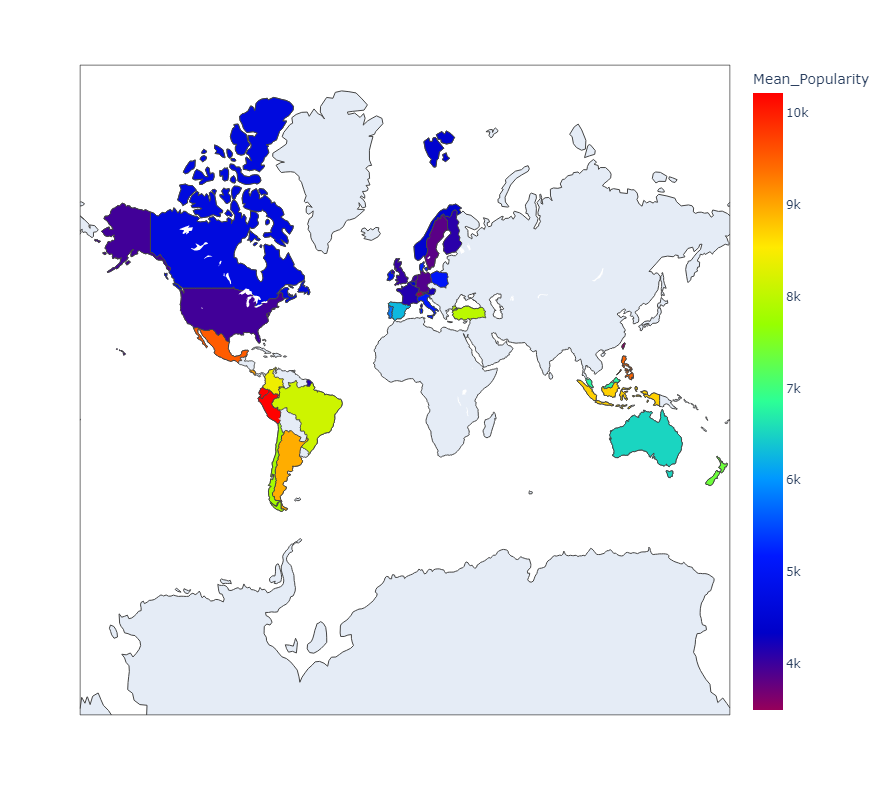

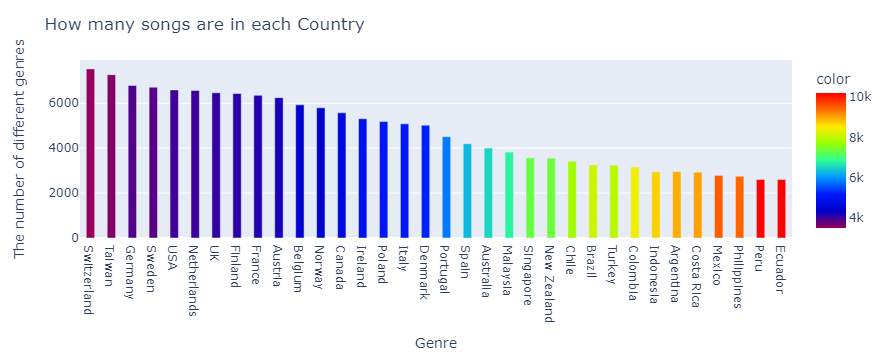

In [54]:
country_list = by_country
fig = px.choropleth(country_list, locations='Country',
                        color='Mean_Popularity', # lifeExp is a column of gapminder
                        hover_name='Country', # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Rainbow,
                        width=800,
                        height=800,
                        projection = 'mercator')
fig.show()

uniq = uniq.sort_values(ascending=False, by = 'Popularity')
fig = px.bar(x=uniq.Country,
             y=uniq.Popularity,
             labels={'x':'Genre',
                     'y':'The number of different genres'},
             color = uniq['Mean_Popularity'],            
             color_continuous_scale = px.colors.sequential.Rainbow)
fig.update_layout(title='How many songs are in each Country')
fig.update_traces(width=0.4)
fig.show()


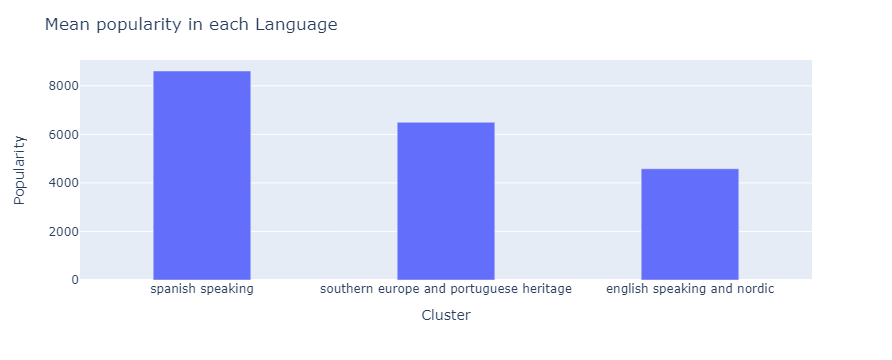

In [55]:
country_popularity = pd.DataFrame(df_1.groupby(['Cluster'])['Popularity'].mean().sort_values(ascending=False))
fig = px.bar(country_popularity,x=country_popularity.index,
             y=country_popularity['Popularity'],
             labels={'x':'Langue of Country',
                     'y':'Mean of Popularity'}
          )
fig.update_layout(title='Mean popularity in each Language')
fig.update_traces(width=0.4)
fig.show()

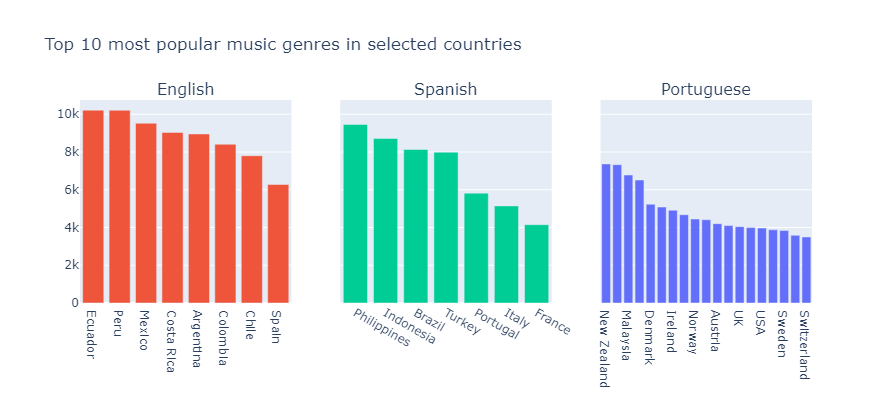

In [91]:
country_en = country[country.Cluster == 'english speaking and nordic'].sort_values(ascending=False, by = 'Mean_Popularity')
country_spanish = country[country.Cluster == 'spanish speaking'].sort_values(ascending=False, by = 'Mean_Popularity')
country_portuguese = country[country.Cluster == 'southern europe and portuguese heritage'].sort_values(ascending=False, by = 'Mean_Popularity')

fig = make_subplots(rows=1, cols=3, subplot_titles=("English", "Spanish", "Portuguese"), shared_yaxes=True)
fig.add_trace(go.Bar(x=country_en.Country, y=country_en.Mean_Popularity), row=1, col=3)
fig.add_trace(go.Bar(x=country_spanish.Country, y=country_spanish.Mean_Popularity), row=1, col=1)
fig.add_trace(go.Bar(x=country_portuguese.Country, y=country_portuguese.Mean_Popularity), row=1, col=2)
fig.update_layout(height=400, width=900,
                  title_text="Top 10 most popular music genres in selected countries", showlegend=False)
fig.show()

In [ ]:
country_en = country[country.Cluster == 'english speaking and nordic'].sort_values(ascending=False, by = 'Mean_Popularity')
fig = px.bar(x=country_en.Country,
             y=country_en.Mean_Popularity,
             labels={'x':'Genre',
                     'y':'The number of different genres'},
             color = country_en['Cluster'],            
             color_continuous_scale = px.colors.sequential.Rainbow)
fig.update_layout(title='How many songs are in each Country')
fig.update_traces(width=0.4)
fig.show()

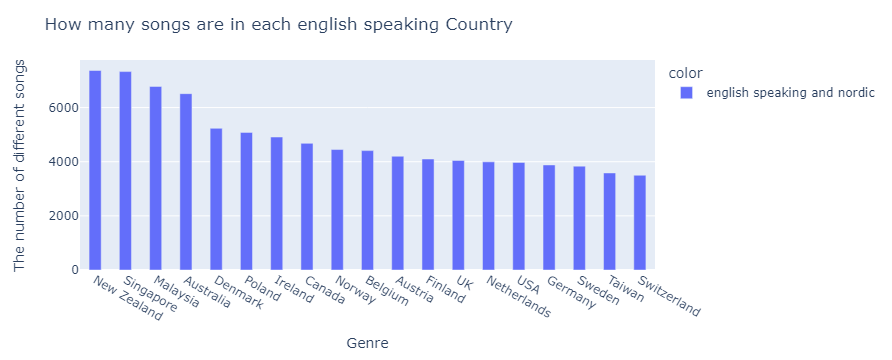

In [82]:
country_en = country[country.Cluster == 'english speaking and nordic'].sort_values(ascending=False, by = 'Mean_Popularity')
fig = px.bar(x=country_en.Country,
             y=country_en.Mean_Popularity,
             labels={'x':'Genre',
                     'y':'The number of different songs'},
             color = country_en['Cluster'],            
             color_continuous_scale = px.colors.sequential.Rainbow)
fig.update_layout(title='How many songs are in each english speaking Country')
fig.update_traces(width=0.4)
fig.show()

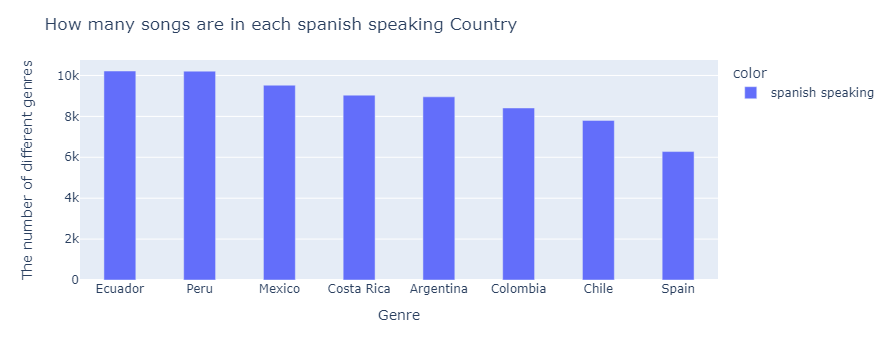

In [83]:
country_spanish = country[country.Cluster == 'spanish speaking'].sort_values(ascending=False, by = 'Mean_Popularity')
fig = px.bar(x=country_spanish.Country,
             y=country_spanish.Mean_Popularity,
             labels={'x':'Genre',
                     'y':'The number of different genres'},
             color = country_spanish['Cluster'],            
             color_continuous_scale = px.colors.sequential.Rainbow)
fig.update_layout(title='How many songs are in each spanish speaking Country')
fig.update_traces(width=0.4)
fig.show()

### Frequency of Artist Followers ????

In [30]:
#casting folat for easier comparison and extrac values
df_1['Artist_followers'] = df_1['Artist_followers'].astype('float')

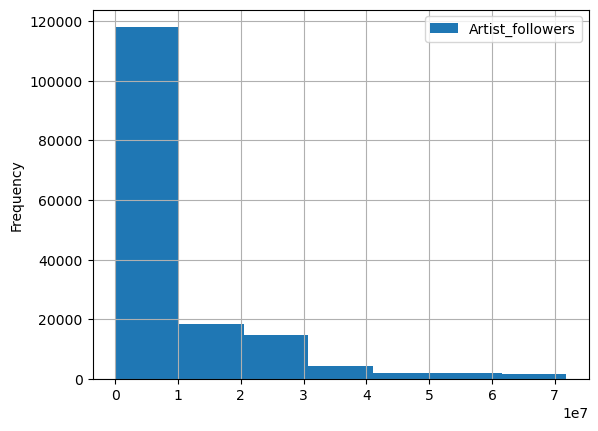

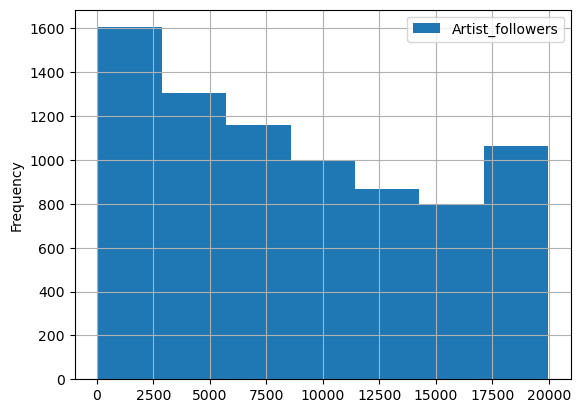

In [15]:
ca = df_1[['Country','Artist_followers']]
ca[['Artist_followers']].plot( kind='hist',grid=True,bins = 7)
pass
ca[ca.Artist_followers < 20000].plot( kind='hist',grid=True,bins = 7)
pass


### Sum popularity by used language in country

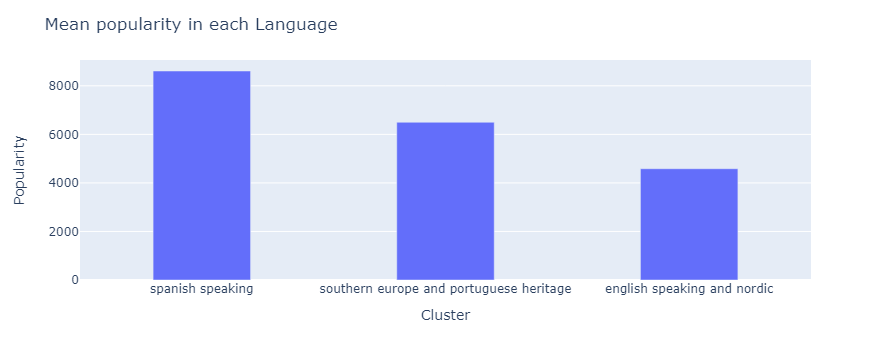

In [ ]:
#How many unique music genres are in the database?

unique_genre_count = df['Genre'].nunique()
unique_genre_count

In [17]:
#How many occurrences of each music genre are there in total in a given country?

count_genre2 = df.groupby('Country')['Genre'].nunique().sort_values(ascending= False)
count_genre2

Country
Sweden         317
Taiwan         300
Norway         299
UK             297
Austria        292
Switzerland    289
Ireland        283
Belgium        277
Germany        268
Netherlands    263
Finland        257
Portugal       257
Poland         253
Canada         232
Denmark        230
USA            218
Australia      215
Spain          213
Malaysia       212
France         211
Italy          209
New Zealand    207
Singapore      206
Turkey         185
Mexico         176
Indonesia      171
Ecuador        166
Costa Rica     166
Chile          165
Philippines    158
Colombia       156
Peru           148
Argentina      143
Brazil         139
Name: Genre, dtype: int64

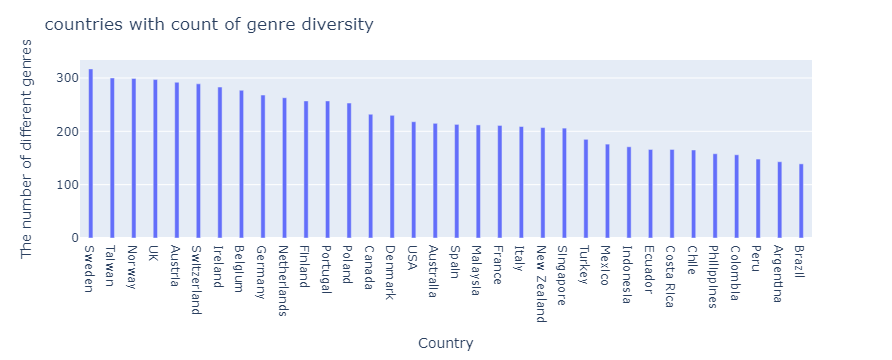

In [18]:
fig = px.bar(x=count_genre2.index, y=count_genre2.values, labels={'x':'Country', 'y':'The number of different genres'})
fig.update_layout(title='countries with count of genre diversity ')
fig.update_traces(width=0.2)
fig.show()

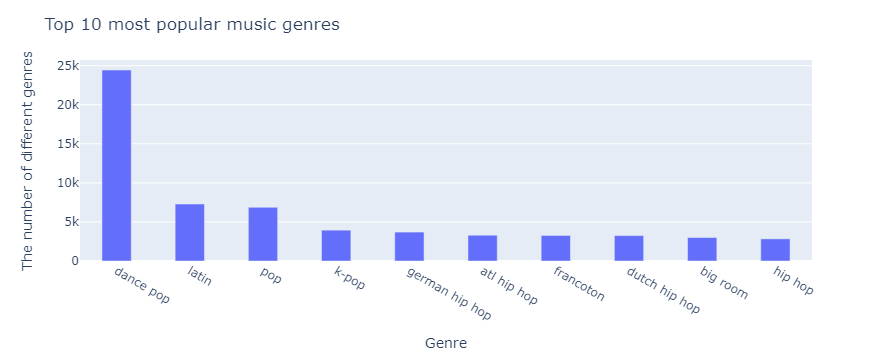

In [19]:
genre_counts = df['Genre'].value_counts().nlargest(10)
fig = px.bar(x=genre_counts.index, y=genre_counts, labels={'x':'Genre', 'y':'The number of different genres'})
fig.update_layout(title='Top 10 most popular music genres')
fig.update_traces(width=0.4)
fig.show()

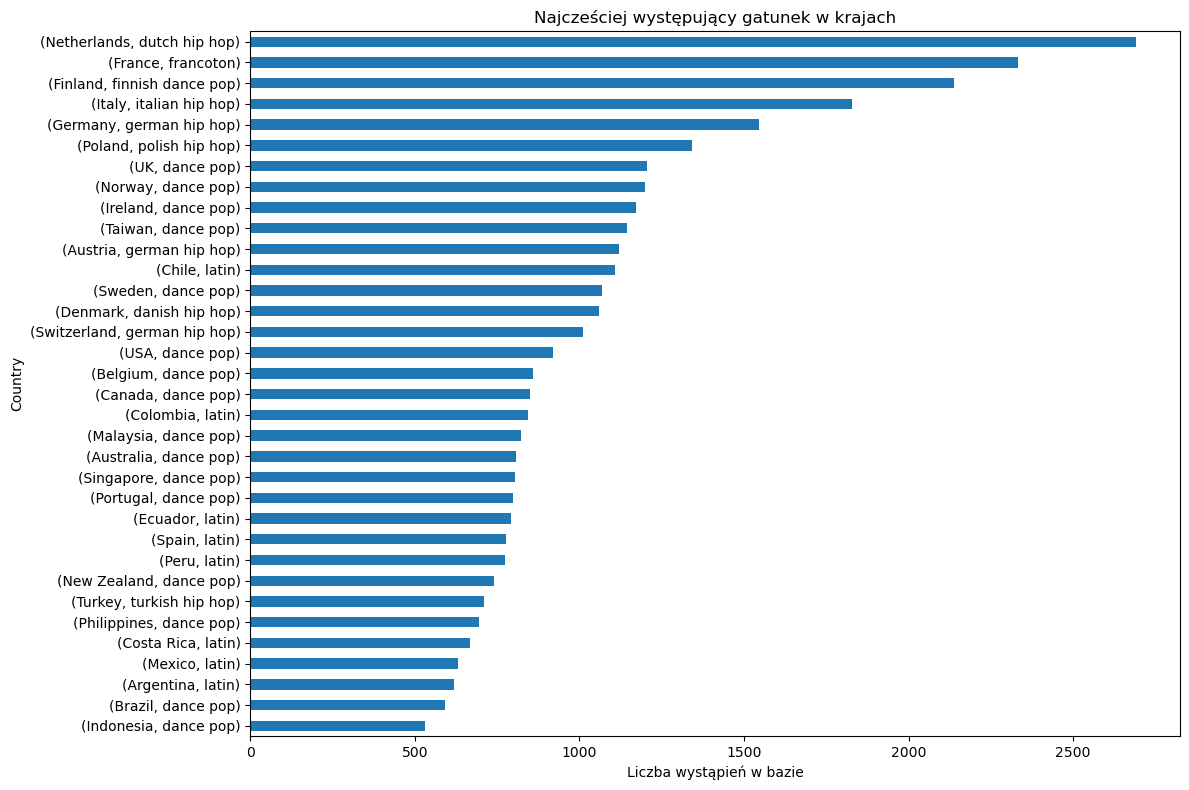

In [20]:
#Which genre is the most commonly listened to in a given country? Number of occurrences

result = df.groupby('Country')['Genre'].apply(lambda x: x.value_counts().nlargest(1)).sort_values(ascending=True)
fig, ax = plt.subplots(figsize=(12, 8))
result.plot(kind='barh', ax=ax)
ax.set_title('Najcześciej występujący gatunek w krajach')
ax.set_xlabel('Liczba wystąpień w bazie')
ax.set_ylabel('Country')
plt.tight_layout()
plt.show()

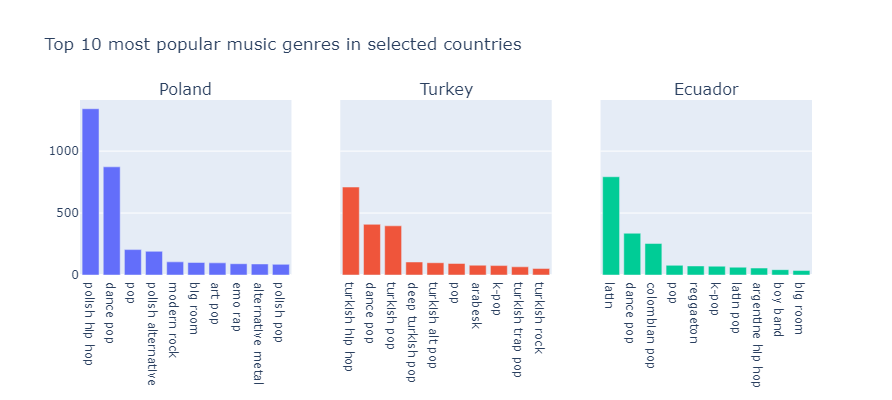

In [23]:
poland_counts = df.query('Country == "Poland"')['Genre'].value_counts().nlargest(10)
turkey_counts = df.query('Country == "Turkey"')['Genre'].value_counts().nlargest(10)
ecuador_counts = df.query('Country == "Ecuador"')['Genre'].value_counts().nlargest(10)
fig = make_subplots(rows=1, cols=3, subplot_titles=("Poland", "Turkey", "Ecuador"), shared_yaxes=True)
fig.add_trace(go.Bar(x=poland_counts.index, y=poland_counts), row=1, col=1)
fig.add_trace(go.Bar(x=turkey_counts.index, y=turkey_counts), row=1, col=2)
fig.add_trace(go.Bar(x=ecuador_counts.index, y=ecuador_counts), row=1, col=3)
fig.update_layout(height=400, width=900,
                  title_text="Top 10 most popular music genres in selected countries", showlegend=False)
fig.show()

Please enter the name of the music genre for which you want to see ordered countries by count:  pop


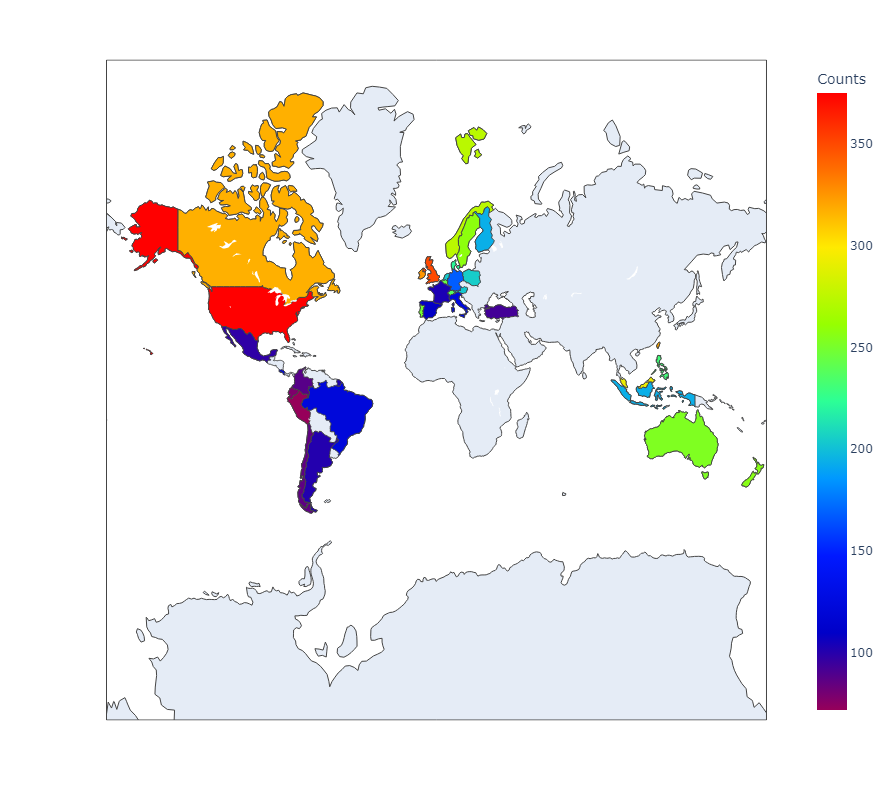

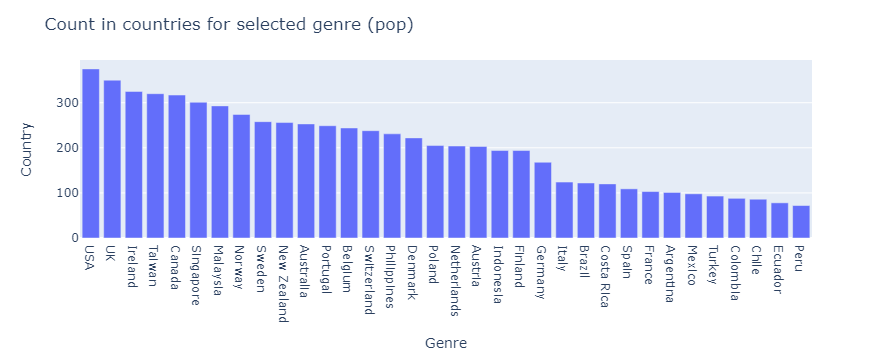

In [22]:
#Display the top 10 countries for selected genre
wprowadzony_gatunek = input("Please enter the name of the music genre for which you want to see ordered countries by count: ")
nowy_df = df.loc[df['Genre'] == wprowadzony_gatunek, ['Genre', 'Country','iso_alpha']]
zliczanie = nowy_df['Country'].value_counts()
zliczanie.columns = ['Country', 'Counts']
top_counts = nowy_df[['iso_alpha','Country']].value_counts().reset_index().rename(columns={0 : 'Counts'})
# poloting map from selected countries
country_list = top_counts
fig = px.choropleth(country_list, locations="iso_alpha",
                        color="Counts", # lifeExp is a column of gapminder
                        hover_name="Country", # column to add to hover information
                        color_continuous_scale=px.colors.sequential.Rainbow,
                        width=800,
                        height=800,
                        projection = 'mercator')
fig.show()
'''One of `'equirectangular'`, `'mercator'`, `'orthographic'`, `'natural
    earth'`, `'kavrayskiy7'`, `'miller'`, `'robinson'`, `'eckert4'`,
    `'azimuthal equal area'`, `'azimuthal equidistant'`, `'conic equal
    area'`, `'conic conformal'`, `'conic equidistant'`, `'gnomonic'`,
    `'stereographic'`, `'mollweide'`, `'hammer'`, `'transverse mercator'`,
    `'albers usa'`, `'winkel tripel'`, `'aitoff'`, or `'sinusoidal'`Default
    depends on `scope`. '''
# poloting bar from selected countries
fig = px.bar(nowy_df, x=top_counts['Country'], y=top_counts['Counts'], labels={'x':'Genre', 'y':'Country'})
fig.update_layout(title=f"Count in countries for selected genre ({wprowadzony_gatunek})")
fig.show()

